# Product Idea for Apps
Explore different apps and app categories to present actionable information

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
df_account = pd.read_csv('../challenge_data/account_dat.csv')
df_app = pd.read_csv('../challenge_data/app_dat.csv')
df_category = pd.read_csv('../challenge_data/category_ref.csv')
df_device = pd.read_csv('../challenge_data/device_ref.csv')
df_in_app = pd.read_csv('../challenge_data/in-app_dat.csv')
df_transaction = pd.read_csv('../challenge_data/transaction_dat.csv')

In [3]:
df_account['create_dt'] = pd.to_datetime(df_account['create_dt'])
df_transaction['create_dt'] = pd.to_datetime(df_transaction['create_dt'])

In [4]:
df_in_app_denorm = df_in_app.join(df_app.set_index('content_id'), on='parent_app_content_id')\
                .join(df_category.set_index('category_id'), on='category_id')\
                .join(df_device.set_index('device_id'), on='device_id')
df_in_app_denorm.head()

,parent_app_content_id,content_id,type,app_name,category_id,device_id,category_name,device_name
0,d2bde35599e0dae9,227227a77c59809b,consumable,lactantem prevailing,Z-1,3,Games,Both
1,d2bde35599e0dae9,41ac2362a2600185,consumable,lactantem prevailing,Z-1,3,Games,Both
2,d2bde35599e0dae9,64a8e16f030bb611,consumable,lactantem prevailing,Z-1,3,Games,Both
3,d2bde35599e0dae9,2c8ba424183afa7c,consumable,lactantem prevailing,Z-1,3,Games,Both
4,d2bde35599e0dae9,b4c42fa5cc420f7b,consumable,lactantem prevailing,Z-1,3,Games,Both


In [5]:
df_app_denorm = df_app.join(df_category.set_index('category_id'), on='category_id')\
                .join(df_device.set_index('device_id'), on='device_id')
df_app_denorm['type'] = 'download_only'
df_app_denorm.head()

,app_name,content_id,category_id,device_id,category_name,device_name,type
0,half-slouched having,22dfac9721b899cb,Y-8,3,Photos & Videos,Both,download_only
1,lift whale-ships,7c645810cd7f166e,M-7,3,Utilities,Both,download_only
2,mightily community,c495bcb878faffaa,Y-8,2,Photos & Videos,iPad,download_only
3,session: too--shall,4e683dcd461cdd22,Y-8,1,Photos & Videos,iPhone,download_only
4,That Zoology,6473dd29a2badbf1,Y-8,3,Photos & Videos,Both,download_only


In [6]:
cols_app = ['app_name', 'content_id', 'type', 'category_name', 'device_name']
df_app_all = pd.concat([df_in_app_denorm[cols_app],
                        df_app_denorm[cols_app]])
df_app_all

,app_name,content_id,type,category_name,device_name
0,lactantem prevailing,227227a77c59809b,consumable,Games,Both
1,lactantem prevailing,41ac2362a2600185,consumable,Games,Both
2,lactantem prevailing,64a8e16f030bb611,consumable,Games,Both
3,lactantem prevailing,2c8ba424183afa7c,consumable,Games,Both
4,lactantem prevailing,b4c42fa5cc420f7b,consumable,Games,Both
...,...,...,...,...,...
995,animals nights--do,71cc78b6addcdc63,download_only,Entertainment,Both
996,meeting-house? respond,42e45e59e6d3dcf1,download_only,Photos & Videos,Both
997,--SIBBALD'S occupation,d862535438d4314c,download_only,Utilities,Both
998,cylinders vain!,07d53efa8e531e15,download_only,Photos & Videos,Both


In [7]:
df_trn_denorm = df_transaction.join(df_device.set_index('device_id'), on='device_id')\
                    .join(df_account.set_index('acct_id'), on='acct_id', lsuffix='_transaction', rsuffix='_acct')

# fill accounts that cannot join to payment_type
df_trn_denorm['payment_type'] = df_trn_denorm['payment_type'].fillna('unknown')

In [8]:
df_wide = df_trn_denorm.join(df_app_all.drop(columns=['device_name'])\
                             .set_index('content_id'), on='content_id')

In [9]:
df_category_stats = df_wide.groupby(by=['payment_type', 'type'], as_index=False)\
                    .agg(revenue=('price', 'sum'), 
                         n_acct=('acct_id','nunique'), 
                         n_content=('content_id', 'nunique'),
                         n_trn=('content_id', 'count'))

df_category_stats['rev_per_trn'] = df_category_stats['revenue']/df_category_stats['n_trn']
df_category_stats['rev_per_acct'] = df_category_stats['revenue']/df_category_stats['n_acct']
df_category_stats['rev_per_cont'] = df_category_stats['revenue']/df_category_stats['n_content']
df_category_stats['n_trn_per_acct'] = df_category_stats['n_trn']/df_category_stats['n_acct']
df_category_stats

,payment_type,type,revenue,n_acct,n_content,n_trn,rev_per_trn,rev_per_acct,rev_per_cont,n_trn_per_acct
0,Free only,download_only,0.00,14993,224,1167271,0.000000,0.000000,0.000000,77.854399
1,PMOF,consumable,16797973.69,14982,2107,1820631,9.226457,1121.210365,7972.460223,121.521225
2,PMOF,download_only,1025178.66,14982,313,425655,2.408473,68.427357,3275.331182,28.411093
3,PMOF,subscription,1214154.90,14982,269,191210,6.349850,81.040909,4513.586989,12.762649
4,unknown,consumable,10822.05,11,853,1195,9.056109,983.822727,12.687046,108.636364
5,unknown,download_only,767.64,25,408,1438,0.533825,30.705600,1.881471,57.520000
6,unknown,subscription,594.91,11,93,109,5.457890,54.082727,6.396882,9.909091


### Exclude 'unknown' payment_type accounts
Only 25 accounts that have 'unknown' payment_type. These accounts seem to have similar behavior as that of 'PMOF' accounts. Let's exclude accounts with 'unknown' payment_type for now

In [10]:
# omit 'unknown' payment_type
df_wide = df_wide[df_wide['payment_type'] != 'unknown']

In [11]:
df_category_stats = df_wide.groupby(by=['payment_type', 'type', 'category_name'], as_index=False)\
                    .agg(revenue=('price', 'sum'), 
                         n_acct=('acct_id','nunique'), 
                         n_content=('content_id', 'nunique'),
                         n_trn=('content_id', 'count'))

df_category_stats['rev_per_trn'] = df_category_stats['revenue']/df_category_stats['n_trn']
df_category_stats['rev_per_acct'] = df_category_stats['revenue']/df_category_stats['n_acct']
df_category_stats['rev_per_cont'] = df_category_stats['revenue']/df_category_stats['n_content']
df_category_stats['n_trn_per_acct'] = df_category_stats['n_trn']/df_category_stats['n_acct']
df_category_stats

,payment_type,type,category_name,revenue,n_acct,n_content,n_trn,rev_per_trn,rev_per_acct,rev_per_cont,n_trn_per_acct
0,Free only,download_only,Entertainment,0.00,14993,39,203488,0.000000,0.000000,0.000000,13.572200
1,Free only,download_only,Games,0.00,14993,78,406380,0.000000,0.000000,0.000000,27.104649
2,Free only,download_only,Photos & Videos,0.00,14993,53,275838,0.000000,0.000000,0.000000,18.397786
3,Free only,download_only,Social Networking,0.00,14515,10,51698,0.000000,0.000000,0.000000,3.561695
4,Free only,download_only,Utilities,0.00,14993,44,229867,0.000000,0.000000,0.000000,15.331621
5,PMOF,consumable,Entertainment,875213.56,14977,184,130544,6.704357,58.437174,4756.595435,8.716298
6,PMOF,consumable,Games,11854078.71,14982,1006,1039829,11.400027,791.221380,11783.378439,69.405220
7,PMOF,consumable,Photos & Videos,2696202.67,14982,585,414333,6.507333,179.962800,4608.893453,27.655386
8,PMOF,consumable,Social Networking,548519.20,14917,122,86580,6.335403,36.771415,4496.059016,5.804116
9,PMOF,consumable,Utilities,823959.55,14980,210,149345,5.517155,55.003975,3923.616905,9.969626


### Let's visualize this in time series

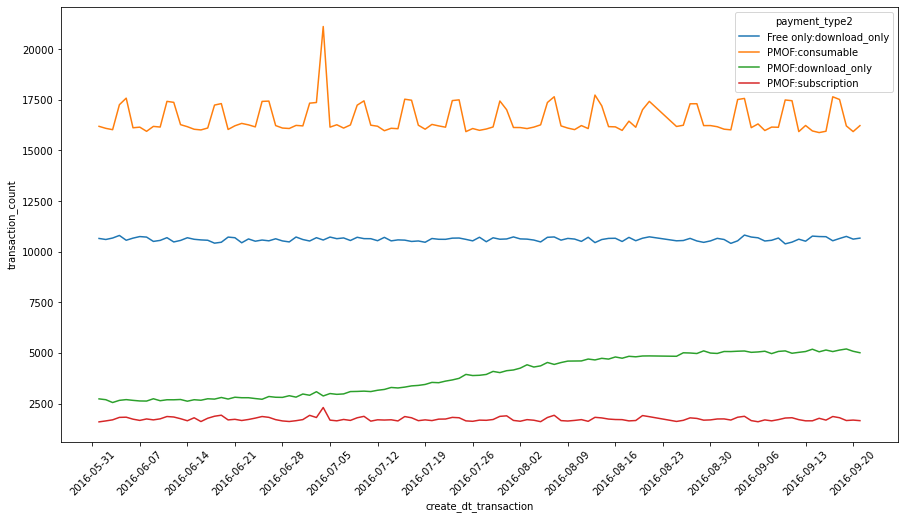

In [12]:
df_wide['payment_type2'] = df_wide['payment_type'] + ':' + df_wide['type']

df_wide3 = df_wide[['create_dt_transaction', 'payment_type2', 'content_id']]\
.groupby(by=['create_dt_transaction', 'payment_type2'], as_index=False).count()

plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
ax = sns.lineplot(x='create_dt_transaction', y='content_id', hue='payment_type2', 
             data=df_wide3)
ax.set_ylabel('transaction_count')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

In [13]:
df_wide3[df_wide3['content_id'] == df_wide3['content_id'].max()]['create_dt_transaction']

133   2016-07-04
Name: create_dt_transaction, dtype: datetime64[ns]

In [14]:
pd.set_option('display.max_rows', 500)

In [15]:
df_wide4 = df_wide[df_wide['type'] == 'consumable'][['create_dt_transaction',  'content_id']]\
.groupby(by=['create_dt_transaction'], as_index=False).count()
df_wide4[(df_wide4['create_dt_transaction'] > '2016-08-18') &
         (df_wide4['create_dt_transaction'] < '2016-08-31')].rename(columns={'content_id':'n_transactions'})

,create_dt_transaction,n_transactions
79,2016-08-19,16146
80,2016-08-20,17011
81,2016-08-21,17424
82,2016-08-25,16184
83,2016-08-26,16245
84,2016-08-27,17304
85,2016-08-28,17307
86,2016-08-29,16228
87,2016-08-30,16229


### July 4th Spike
I see a spike in transactions for in_app content of consumable and subscription

### Missing Data
I see a data gap on 2016-08-22 to 2016-08-24, inclusive. This is a data gap, not a shift in data, because following the gap, the weekends following the gap retains the increase in spending as before the gap. We should work with engineering to reprocess and backfill this data

### Increase in PMOF account download of apps
I see increase in PMOF accounts downloading apps over time. Let's take a deeper look at this to better understand why it is increasing.

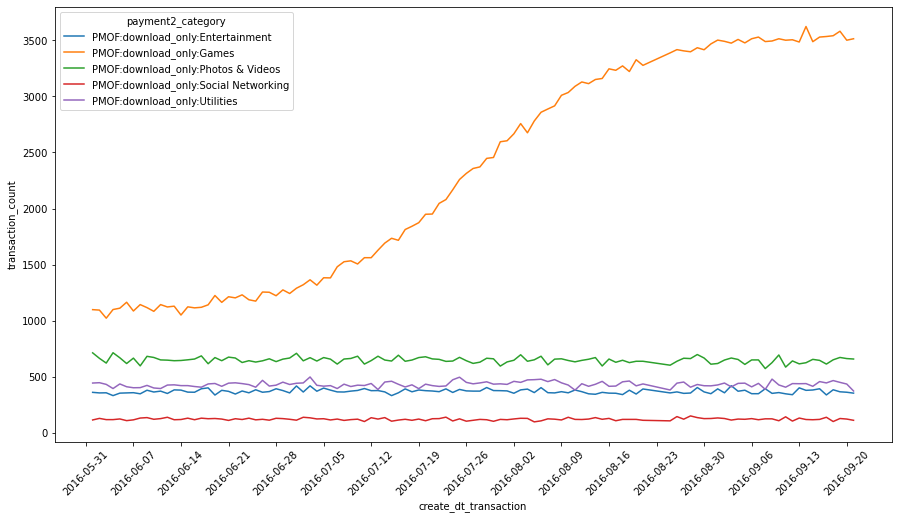

In [16]:
df_wide['payment2_category'] = df_wide['payment_type2'] + ':' + df_wide['category_name']

df_wide_sub5 = df_wide[df_wide['payment_type2'] == 'PMOF:download_only']

df_wide5 = df_wide_sub5[['create_dt_transaction', 'payment2_category', 'price']]\
.groupby(by=['create_dt_transaction', 'payment2_category'], as_index=False).count()

plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
ax = sns.lineplot(x='create_dt_transaction', y='price', hue='payment2_category', 
             data=df_wide5)
ax.set_ylabel('transaction_count')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

The increase in daily app downloads for PMOF accounts is coming from Games. What type of games?

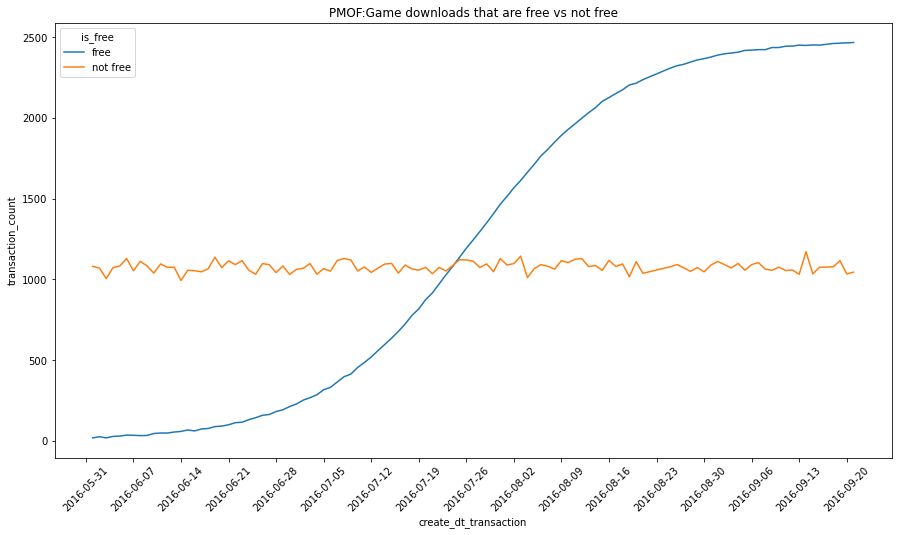

In [36]:
# Let's label transactions with price>0
df_wide['is_free'] = np.where(df_wide['price'] == 0, "free", "not free")

df_wide['payment2_category'] = df_wide['payment_type2'] + ':' + df_wide['category_name']

df_wide_sub5 = df_wide[(df_wide['payment_type2'] == 'PMOF:download_only') &
                       (df_wide['category_name'] == 'Games')]

df_wide5 = df_wide_sub5[['create_dt_transaction', 'is_free', 'price']]\
.groupby(by=['create_dt_transaction', 'is_free'], as_index=False).count()

plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
ax = sns.lineplot(x='create_dt_transaction', y='price', hue='is_free', 
             data=df_wide5)
ax.set_title('PMOF:Game downloads that are free vs not free')
ax.set_ylabel('transaction_count')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

In [44]:
# save output to csv for plotting in visualization program
df_wide5.rename(columns={"price":"app_downloads"}, inplace=True)

df_wide5_pivot = df_wide5.pivot(index='create_dt_transaction', columns='is_free', values='app_downloads')
df_wide5_pivot.reset_index(inplace=True)

df_wide5_pivot.to_csv("pmof_free_downloads.csv", index=False)

### Free game downloads for PMOF accounts
We see that the increase in PMOF game download transactions is coming from games that cost zero dollars to download. What are these games?

In [18]:
pmof_free_apps = df_wide[(df_wide['price'] == 0) & 
                    (df_wide['payment_type'] == 'PMOF') &
                    (df_wide['type'] == 'download_only')]['app_name'].unique()
pmof_free_apps

array(['unwritten hungry', 'words: hospitable', 'skylarking creed',
       'rejoined half-seen', 'altar bevy', 'silent Title:',
       'HIM) pivot-hole', 'remote remaining', 'twos superfluousness',
       'done; sill', 'Bonapartes anatomical', 'freezing shivering',
       'profoundest who'], dtype=object)

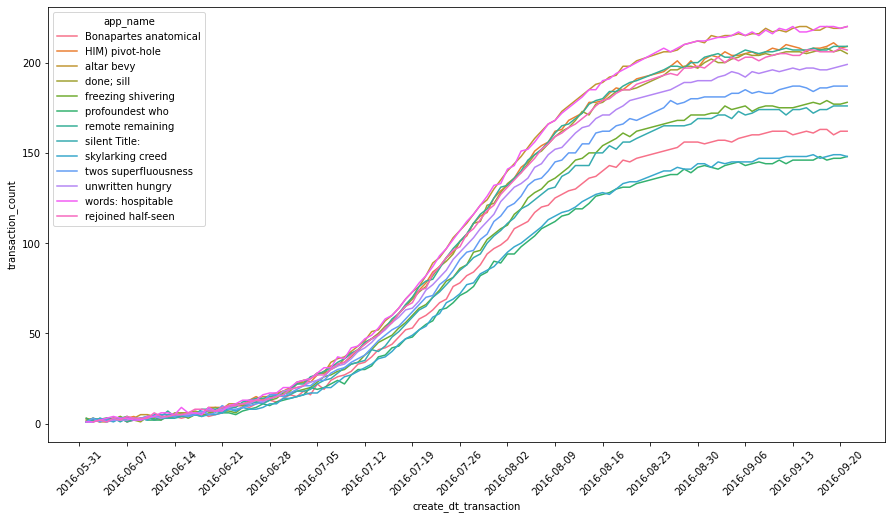

In [19]:
# game app price==0 download
df_wide_sub5 = df_wide[(df_wide['price'] == 0) & (df_wide['payment_type'] == 'PMOF') &
                       (df_wide['type'] == 'download_only')]

df_wide5 = df_wide_sub5[['create_dt_transaction', 'app_name', 'price']]\
.groupby(by=['create_dt_transaction', 'app_name'], as_index=False).count()

plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
ax = sns.lineplot(x='create_dt_transaction', y='price', hue='app_name', 
             data=df_wide5)
ax.set_ylabel('transaction_count')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

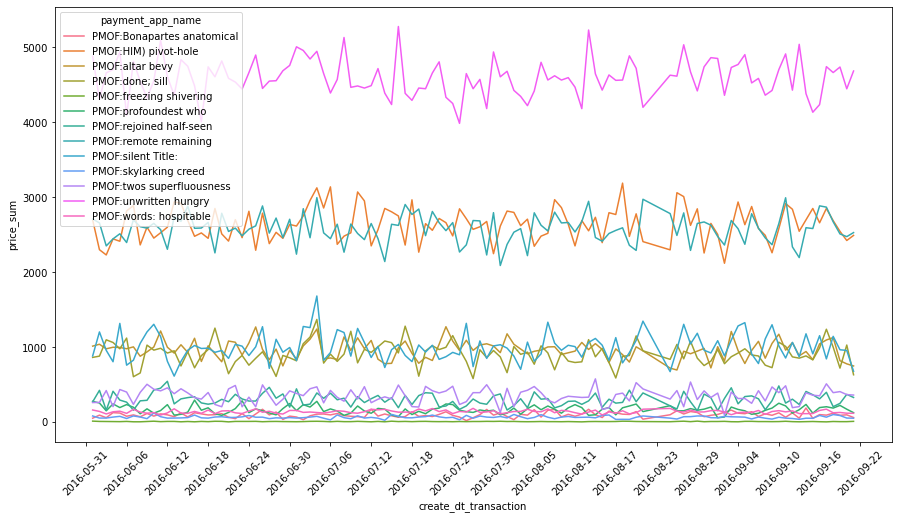

In [20]:
# revenue of game apps with free download
sub_apps = df_wide[(df_wide['price'] == 0) & (df_wide['payment_type'] == 'PMOF')]['app_name'].unique()
df_wide['payment_app_name'] = df_wide['payment_type'] + ':' + df_wide['app_name']

df_wide_sub5 = df_wide[np.isin(df_wide['app_name'],sub_apps)]

df_wide5 = df_wide_sub5[['create_dt_transaction', 'payment_app_name', 'price']]\
.groupby(by=['create_dt_transaction', 'payment_app_name'], as_index=False).sum()

plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
ax = sns.lineplot(x='create_dt_transaction', y='price', hue='payment_app_name', 
             data=df_wide5)
ax.set_ylabel('price_sum')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=6))

daily revenue for these apps seem stable

In [21]:
df_wide[df_wide['app_name'].isin(pmof_free_apps)]\
.groupby(by=['payment_type', 'app_name']).agg(n_acct=('acct_id','nunique'))

n_acct
payment_type app_name                     
PMOF         Bonapartes anatomical    9331
             HIM) pivot-hole         13549
             altar bevy              13381
             done; sill              12453
             freezing shivering       9881
             profoundest who          8616
             rejoined half-seen      11705
             remote remaining        14474
             silent Title:           11411
             skylarking creed         8868
             twos superfluousness    10750
             unwritten hungry        14878
             words: hospitable       12892

In [22]:
df_wide[df_wide['payment_type'] == 'PMOF']['acct_id'].nunique()

14982

These free download apps are very popular with PMOF accounts.

### Calculate the app stats omitting these PMOF free apps
These 13 free download apps for PMOF accounts are an exception to the normal PMOF download behavior. Let us exclude them and calculate the category stats as before

In [23]:
df_category_stats = df_wide[~df_wide['app_name'].isin(pmof_free_apps)]\
                    .groupby(by=['payment_type', 'type', 'category_name'], as_index=False)\
                    .agg(revenue=('price', 'sum'), 
                         n_acct=('acct_id','nunique'), 
                         n_content=('content_id', 'nunique'),
                         n_trn=('content_id', 'count'))

df_category_stats['rev_per_trn'] = df_category_stats['revenue']/df_category_stats['n_trn']
df_category_stats['rev_per_acct'] = df_category_stats['revenue']/df_category_stats['n_acct']
df_category_stats['rev_per_cont'] = df_category_stats['revenue']/df_category_stats['n_content']
df_category_stats['n_trn_per_acct'] = df_category_stats['n_trn']/df_category_stats['n_acct']
df_category_stats

,payment_type,type,category_name,revenue,n_acct,n_content,n_trn,rev_per_trn,rev_per_acct,rev_per_cont,n_trn_per_acct
0,Free only,download_only,Entertainment,0.00,14993,39,203488,0.000000,0.000000,0.000000,13.572200
1,Free only,download_only,Games,0.00,14993,78,406380,0.000000,0.000000,0.000000,27.104649
2,Free only,download_only,Photos & Videos,0.00,14993,53,275838,0.000000,0.000000,0.000000,18.397786
3,Free only,download_only,Social Networking,0.00,14515,10,51698,0.000000,0.000000,0.000000,3.561695
4,Free only,download_only,Utilities,0.00,14993,44,229867,0.000000,0.000000,0.000000,15.331621
5,PMOF,consumable,Entertainment,875213.56,14977,184,130544,6.704357,58.437174,4756.595435,8.716298
6,PMOF,consumable,Games,10335651.37,14982,923,900563,11.476878,689.871270,11197.888808,60.109665
7,PMOF,consumable,Photos & Videos,2696202.67,14982,585,414333,6.507333,179.962800,4608.893453,27.655386
8,PMOF,consumable,Social Networking,548519.20,14917,122,86580,6.335403,36.771415,4496.059016,5.804116
9,PMOF,consumable,Utilities,823959.55,14980,210,149345,5.517155,55.003975,3923.616905,9.969626


In [24]:
df_category_stats[df_category_stats['type'] == 'download_only']\
.pivot(index='category_name', columns=['payment_type'], values='n_trn_per_acct')

payment_type,Free only,PMOF
category_name,,
Entertainment,13.572200,2.911240
Games,27.104649,7.912077
Photos & Videos,18.397786,4.814411
Social Networking,3.561695,1.526203
Utilities,15.331621,3.308312


### Extra
Some other questions that are interesting to ask

In [25]:
# I wonder if there are PMOF and free versions of the same app
# from following results. doesn't seem to be relationship between app_names
df_wide[(df_wide['type'] == 'download_only') &
        (df_wide['category_name'] == 'Social Networking')]\
.groupby(by=['payment_type', 'app_name']).agg(n_acct=('acct_id','nunique'))

n_acct
payment_type app_name                      
Free only    Cape-Horner azimuth       4383
             FRENCH couple             4341
             combat ETEXTSSTART        4334
             darker Japanese           4398
             enough--so whale;         4422
             essential whetstones      4412
             night's discover          4407
             socks hopefully           4326
             thou? bunch               4318
             whale-lance spring        4320
PMOF         Stammering warriors       1026
             Thine haint                920
             appellations; toes         897
             chief-mateship antique     889
             cove! random               957
             crosswise Where            904
             end? sadder                936
             infallibly unbroken        936
             restraint; name)           942
             revellers reckoning        982
             sincerity arrested         899
             voyage; custom             913
             wales dinner               973
             whale! unsurrenderable     913

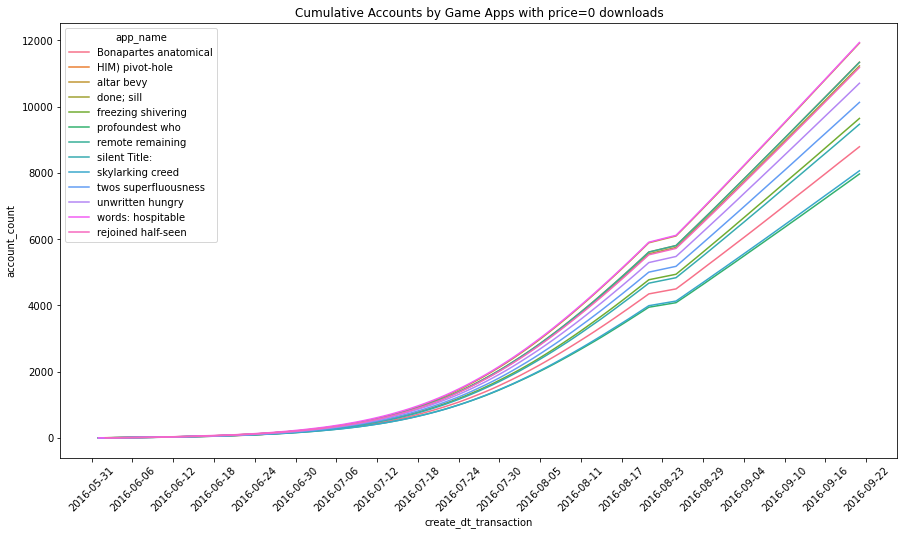

In [26]:
# cumulative sum of account_ids by app_name
df_wide_sub5 = df_wide[(df_wide['price'] == 0) & (df_wide['payment_type'] == 'PMOF')]

df_wide5 = df_wide_sub5[['create_dt_transaction', 'app_name', 'acct_id']]\
.groupby(by=['create_dt_transaction', 'app_name']).nunique()\
.groupby(level=1).cumsum().reset_index()

plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
ax = sns.lineplot(x='create_dt_transaction', y='acct_id', hue='app_name', 
             data=df_wide5)
ax.set_ylabel('account_count')
ax.set_title('Cumulative Accounts by Game Apps with price=0 downloads')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=6))

In [27]:
# why is there so many download transactions in 'Free only' accounts?

df_category_stats = df_wide[(df_wide['payment_type'] == 'Free only') &
                            (df_wide['category_name'] == 'Games')]\
                    .groupby(by=['app_name'], as_index=False)\
                    .agg(revenue=('price', 'sum'), 
                         n_acct=('acct_id','nunique'), 
                         n_content=('content_id', 'nunique'),
                         n_trn=('content_id', 'count'))

df_category_stats['rev_per_trn'] = df_category_stats['revenue']/df_category_stats['n_trn']
df_category_stats['rev_per_acct'] = df_category_stats['revenue']/df_category_stats['n_acct']
df_category_stats['rev_per_cont'] = df_category_stats['revenue']/df_category_stats['n_content']
df_category_stats.head()

,app_name,revenue,n_acct,n_content,n_trn,rev_per_trn,rev_per_acct,rev_per_cont
0,(KILLER)--Of surprised,0.0,4425,1,5246,0.0,0.0,0.0
1,--PARADISE then',0.0,4386,1,5191,0.0,0.0,0.0
2,Artedi; 41,0.0,4419,1,5205,0.0,0.0,0.0
3,Coffin; requirest,0.0,4402,1,5180,0.0,0.0,0.0
4,FORECASTLE] spoiling,0.0,4426,1,5193,0.0,0.0,0.0


In [28]:
# multiple downloads? let's look at an account's transactions when it has multiple transactions for the same app
df_wide[(df_wide['app_name'] == '(KILLER)--Of surprised')]\
                    .groupby(by=['acct_id'], as_index=False)\
                    .agg(revenue=('price', 'sum'), 
                         n_acct=('acct_id','nunique'), 
                         n_content=('content_id', 'nunique'),
                         n_trn=('content_id', 'count'))\
                    .sort_values(by='n_trn', ascending=False).head()

,acct_id,revenue,n_acct,n_content,n_trn
3579,cea5db621d3dfa0a,0.0,1,1,4
3070,b11f04763ccb6884,0.0,1,1,4
3779,dad511abb72ea3d7,0.0,1,1,4
183,0a693e2e897fac40,0.0,1,1,4
942,34c98285d33b3223,0.0,1,1,4


In [29]:
pd.set_option('display.max_rows', 500)

In [30]:
df_wide[df_wide['acct_id'] == 'cea5db621d3dfa0a'].sort_values(by=['app_name', 'create_dt_transaction'])

,create_dt_transaction,content_id,acct_id,price,device_id,device_name,create_dt_acct,payment_type,app_name,type,category_name,payment_type2,payment2_category,is_free,payment_app_name
2400434,2016-06-05,1051fd41c9b7dcd8,cea5db621d3dfa0a,0.0,1,iPhone,2013-07-23,Free only,(KILLER)--Of surprised,download_only,Games,Free only:download_only,Free only:download_only:Games,free,Free only:(KILLER)--Of surprised
2862898,2016-07-12,1051fd41c9b7dcd8,cea5db621d3dfa0a,0.0,1,iPhone,2013-07-23,Free only,(KILLER)--Of surprised,download_only,Games,Free only:download_only,Free only:download_only:Games,free,Free only:(KILLER)--Of surprised
2852438,2016-08-27,1051fd41c9b7dcd8,cea5db621d3dfa0a,0.0,1,iPhone,2013-07-23,Free only,(KILLER)--Of surprised,download_only,Games,Free only:download_only,Free only:download_only:Games,free,Free only:(KILLER)--Of surprised
2643826,2016-09-20,1051fd41c9b7dcd8,cea5db621d3dfa0a,0.0,1,iPhone,2013-07-23,Free only,(KILLER)--Of surprised,download_only,Games,Free only:download_only,Free only:download_only:Games,free,Free only:(KILLER)--Of surprised
2559783,2016-07-24,b8fc344896ae37e6,cea5db621d3dfa0a,0.0,2,iPad,2013-07-23,Free only,BOOKS bird--airley,download_only,Utilities,Free only:download_only,Free only:download_only:Utilities,free,Free only:BOOKS bird--airley
2798667,2016-06-10,f2d4dd06e9267e20,cea5db621d3dfa0a,0.0,1,iPhone,2013-07-23,Free only,Charity (we,download_only,Photos & Videos,Free only:download_only,Free only:download_only:Photos & Videos,free,Free only:Charity (we
2536402,2016-08-29,605713cb904dc5da,cea5db621d3dfa0a,0.0,1,iPhone,2013-07-23,Free only,Jonah? LAY,download_only,Games,Free only:download_only,Free only:download_only:Games,free,Free only:Jonah? LAY
1954208,2016-06-13,ee4e8290e7622e10,cea5db621d3dfa0a,0.0,2,iPad,2013-07-23,Free only,NANTUCKET up;,download_only,Games,Free only:download_only,Free only:download_only:Games,free,Free only:NANTUCKET up;
1800923,2016-08-04,9b18a2bbdf71ffd7,cea5db621d3dfa0a,0.0,1,iPhone,2013-07-23,Free only,Narwhale--however Straits,download_only,Games,Free only:download_only,Free only:download_only:Games,free,Free only:Narwhale--however Straits
1839305,2016-06-10,40a6760d2a31d618,cea5db621d3dfa0a,0.0,2,iPad,2013-07-23,Free only,Third doubts,download_only,Photos & Videos,Free only:download_only,Free only:download_only:Photos & Videos,free,Free only:Third doubts


In [31]:
# check app downloads for 'PMOF' accounts. do they also have multiple downloads?

df_category_stats = df_wide[(df_wide['payment_type'] == 'PMOF') &
                            (df_wide['type'] == 'download_only') &
                            (df_wide['category_name'] == 'Games')]\
                    .groupby(by=['app_name'], as_index=False)\
                    .agg(revenue=('price', 'sum'), 
                         n_acct=('acct_id','nunique'), 
                         n_content=('content_id', 'nunique'),
                         n_trn=('content_id', 'count'))

df_category_stats['rev_per_trn'] = df_category_stats['revenue']/df_category_stats['n_trn']
df_category_stats['rev_per_acct'] = df_category_stats['revenue']/df_category_stats['n_acct']
df_category_stats['rev_per_cont'] = df_category_stats['revenue']/df_category_stats['n_content']
df_category_stats.head()

,app_name,revenue,n_acct,n_content,n_trn,rev_per_trn,rev_per_acct,rev_per_cont
0,Air FIFE,8459.59,908,1,941,8.99,9.316729,8459.59
1,Bildad? Files,951.39,937,1,961,0.99,1.015358,951.39
2,Bonapartes anatomical,0.00,8790,1,8790,0.00,0.000000,0.00
3,Cannon Yojo's,1000.89,976,1,1011,0.99,1.025502,1000.89
4,China; TALBOT,5119.74,990,1,1026,4.99,5.171455,5119.74


Yes some PMOF accounts have multiple downloads as seen in n_trn>n_acct. More downloads than accounts